In [ ]:
from data_structures import *
from helpers import *
import matplotlib.pyplot as plt
import numpy as np

params = Params(
    H = 0.001,
    mu = 0.001,
    rho = 1000,
    T_in = 298,
    T_w = 373,
    cp = 4186,
    k = 60,
    L = 1.0,
    U_in = 1.0,
    Ldev = 0.05
)

In [74]:

def mdf_assemblage(X : tuple, Y : tuple, nx : int, ny : int, params : Params):
    """ Fonction assemblant la matrice A et le vecteur b

    Entrées:
        - X : Bornes du domaine en x, X = [x_min, x_max]
        - Y : Bornes du domaine en y, Y = [y_min, y_max]
        - nx : Discrétisation de l'espace en x (nombre de points)
        - ny : Discrétisation de l'espace en y (nombre de points)
        - params : Structure de données contenant les paramètres physiques du problème

    Sorties (dans l'ordre énuméré ci-bas):
        - A : Matrice (array)
        - b : Vecteur (array)
    """
    

    x_mat, y_mat = position(X, Y, nx, ny)
    

    dx = (X[1] - X[0]) / (nx - 1)
    dy = (Y[1] - Y[0]) / (ny - 1)

    #Simplification des paramètres
    const = params.rho * params.cp /2/params.k/dx

    N = nx * ny
    A = np.zeros((N, N))
    B = np.zeros(N)

    # Dirichlet 
    T_edge = params.T_w
    T_entrée = params.T_in


    for i in range(ny):
        for j in range(nx):
            k = idx(i, j, ny)

            #Détection des bords
            gauche_lim   = (j == 0)
            droite_lim  = (j == nx - 1)
            haut_lim    = (i == 0)         
            bas_lim = (i == ny - 1)

            # Supposer que les conditions T_w appliqué en haut et bas sont prioritaires?
            
            if gauche_lim:
                A[k, k] = 1.0
                B[k] = T_entrée
            elif droite_lim:
                pass
                #TODO : Faire la condition de Neumann à droite ici 
                A[k, k] = 3/2/dx
                k_gauche = idx(i, j - 1, ny)
                k_gauche2 = idx(i, j - 2, ny)
                A[k, k_gauche] = -2/dx
                A[k, k_gauche2] = 1/2/dx
                B[k] = 0
            elif haut_lim or bas_lim:
                    A[k, k] = 1.0
                    B[k] = T_edge

            else:
                # ---- Interior / Neumann edges ----
                u = vitesse(x_mat[i, j], y_mat[i, j], params)[0]
                #évaluation de v même si on ne l'utilise pas, vitesse nulle

                #possible utilisation du programme dans le futur avec v non nul
                v = vitesse(x_mat[i, j], y_mat[i, j], params)[1]

                #Évaluation des indices k pour les voisins
                k_gauche = idx(i, j - 1, ny)
                k_droite = idx(i, j + 1, ny)
                k_haut = idx(i - 1, j, ny)
                k_bas = idx(i + 1, j, ny)

                # Assemblage de la matrice A et du vecteur b
                A[k, k] = 2/dx/dx + 2/dy/dy
                A[k, k_gauche] = -const*u - 1/dx/dx
                A[k, k_droite] = const*u - 1/dx/dx
                A[k, k_bas] = -1/dy/dy
                A[k, k_haut] = -1/dy/dy
                B[k] = 0
    return A, B


In [75]:

nx, ny = 50, 50


A, B = mdf_assemblage((0, params.L), (-params.H/2, params.H/2), nx, ny, params)
T = np.linalg.solve(A, B)   # T de taille N = nx*ny



x_mat, y_mat = position((0, params.L), (-params.H/2, params.H/2), nx, ny)
T_mat = vecteur_en_matrice(T, nx, ny)



In [76]:
#Construction de la matrice vitesses (x car vy est nul)
U_mat = np.zeros((ny, nx))
for i in range(ny):
    for j in range(nx):
        U_mat[i, j] = vitesse(x_mat[i, j], y_mat[i, j], params)[0]

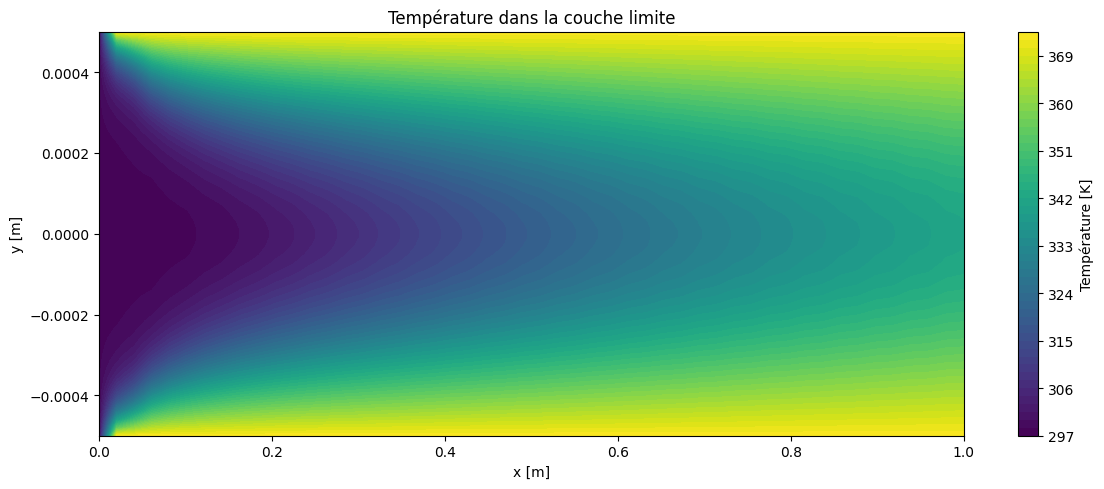

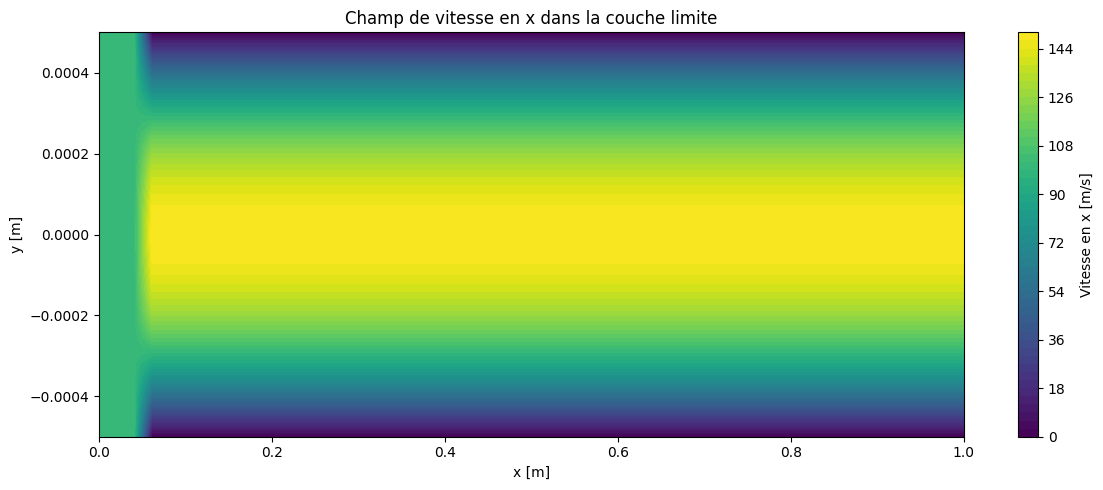

In [77]:
plt.figure(figsize=(12, 5))
niveaux = 50  # nombre de niveaux de contour
cf = plt.contourf(x_mat, y_mat, T_mat, levels=niveaux)
plt.colorbar(cf, label="Température [K]")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Température dans la couche limite")
plt.tight_layout()
plt.show()

#Visulisation du champ de vitesse
plt.figure(figsize=(12, 5))
cf = plt.contourf(x_mat, y_mat, U_mat, levels=niveaux)
plt.colorbar(cf, label="Vitesse en x [m/s]")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Champ de vitesse en x dans la couche limite")
plt.tight_layout()
plt.show()